In [102]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

torch.Size([1, 32, 32])
Image([[[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]], )


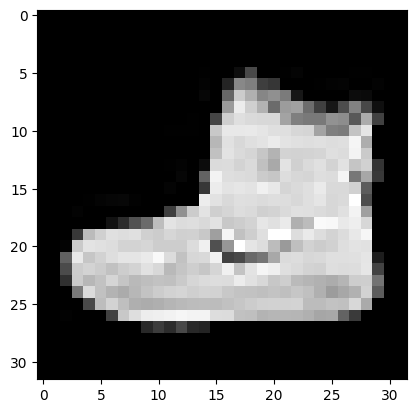

In [43]:
transform = v2.Compose(
    [
        v2.Pad(2),
        v2.ToImageTensor(),
        v2.ConvertImageDtype(),
    ]
)

train_dataset = torchvision.datasets.FashionMNIST(
    root="./dataset", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root="./dataset", train=False, download=True, transform=transform
)

print(train_dataset[0][0].shape)
print(train_dataset[0][0])
plt.imshow(train_dataset[0][0].squeeze(), cmap="grey")

In [44]:
class Encoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1
        )  # 16 x 16
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1
        )  # 8 x 8
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1
        )  # 4 x 4
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(in_features=128 * 4 * 4, out_features=2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        out = self.conv3(out)
        out = self.activation(out)
        out = self.flatten(out)
        out = self.dense(out)
        return out


encoder = Encoder()
sample = train_dataset[0][0].unsqueeze(0)
print(sample.shape)
pred = encoder(sample)
print(pred.shape)

torch.Size([1, 1, 32, 32])
torch.Size([1, 2])


In [71]:
class Decoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.dense = nn.Linear(in_features=2, out_features=128 * 4 * 4)
        self.conv_tr1 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.conv_tr2 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.conv_tr3 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.conv = nn.Conv2d(
            in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1
        )
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.dense(x)
        out = out.reshape([-1, 128, 4, 4])
        out = self.conv_tr1(out)
        out = self.activation(out)
        out = self.conv_tr2(out)
        out = self.activation(out)
        out = self.conv_tr3(out)
        out = self.activation(out)
        out = self.conv(out)
        out = self.sigmoid(out)
        return out


decoder = Decoder()
sample = torch.randn([4, 2])
pred = decoder(sample)
print(pred.shape)

torch.Size([4, 1, 32, 32])


In [72]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out, latent

In [73]:
def train(model, train_dl, n_epoch, lr, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(n_epoch):
        encoder.train()
        decoder.train()
        pbar = tqdm(train_dl)
        pbar.set_description(f"epoch[{epoch}]")
        loss_sum = 0
        total_cnt = 0
        for _, (x, _) in enumerate(pbar):
            optimizer.zero_grad()
            x = x.to(device)
            pred, _ = model(x)
            x_compare = x.reshape(x.shape[0], -1)
            pred_compare = pred.reshape(pred.shape[0], -1)
            loss = criterion(pred_compare, x_compare)
            loss_sum += loss.item() * x.shape[0]
            total_cnt += x.shape[0]
            pbar.set_postfix_str(f"loss:{loss.item()}")
            loss.backward()
            optimizer.step()
        print(f"epoch[{epoch}], loss mean : {loss_sum/total_cnt}")

In [78]:
encoder = Encoder()
decoder = Decoder()
model = AutoEncoder(encoder, decoder)
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
train(model, train_dl, 10, 1e-4, device)

epoch[0]: 100%|██████████| 469/469 [00:07<00:00, 64.80it/s, loss:0.03581774979829788] 


epoch[0], loss mean : 0.06973458142677944


epoch[1]: 100%|██████████| 469/469 [00:07<00:00, 65.03it/s, loss:0.025812944397330284]


epoch[1], loss mean : 0.03179147842824459


epoch[2]: 100%|██████████| 469/469 [00:07<00:00, 63.77it/s, loss:0.029806118458509445]


epoch[2], loss mean : 0.029550842966636022


epoch[3]: 100%|██████████| 469/469 [00:07<00:00, 62.64it/s, loss:0.03132909536361694] 


epoch[3], loss mean : 0.02849081867535909


epoch[4]: 100%|██████████| 469/469 [00:07<00:00, 64.79it/s, loss:0.027005475014448166]


epoch[4], loss mean : 0.027638691463073094


epoch[5]: 100%|██████████| 469/469 [00:07<00:00, 63.20it/s, loss:0.027362149208784103]


epoch[5], loss mean : 0.026952364526192346


epoch[6]: 100%|██████████| 469/469 [00:07<00:00, 64.85it/s, loss:0.02615172043442726] 


epoch[6], loss mean : 0.026379560480515162


epoch[7]: 100%|██████████| 469/469 [00:07<00:00, 64.41it/s, loss:0.02603897824883461] 


epoch[7], loss mean : 0.025871479453643164


epoch[8]: 100%|██████████| 469/469 [00:07<00:00, 64.83it/s, loss:0.025836212560534477]


epoch[8], loss mean : 0.02546265955865383


epoch[9]: 100%|██████████| 469/469 [00:07<00:00, 64.44it/s, loss:0.025508848950266838]

epoch[9], loss mean : 0.025103686528404553


In [97]:
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=False)
x, test_y = next(iter(test_dl))
x = x.to(device)
pred, latent = model(x)
latent = latent.detach().cpu().numpy()

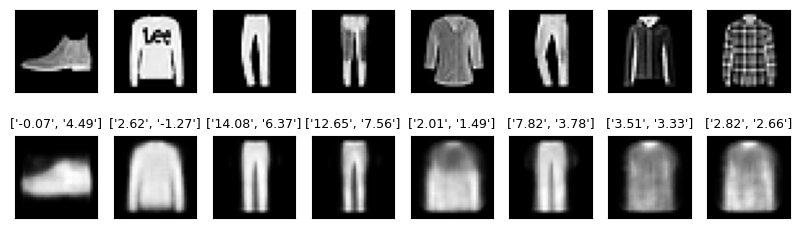

In [98]:
img =  x[0].detach().cpu().squeeze().numpy()


fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(10,3))

for i in range(8):
    x_img = x[i].detach().cpu().squeeze().numpy()
    pred_img = pred[i].detach().cpu().squeeze().numpy()
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])

    axs[0, i].imshow(x_img, cmap="grey")
    axs[1, i].imshow(pred_img, cmap="grey")

    latent_value = [f"{x:.2f}" for x in latent[i]]
    axs[1, i].set_title(latent_value, fontsize=9)



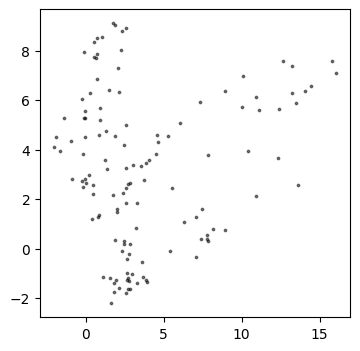

In [101]:
plt.figure(figsize=(4,4))
plt.scatter(latent[:, 0], latent[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [114]:
y_total = []
latent_total = []
for step, (x, y) in enumerate(test_dl):
    x = x.to(device)
    latent = model.encoder(x)
    latent = latent.detach().cpu().numpy()
    latent_total.extend(latent)
    y_total.extend(y.numpy())

y_total = np.array(y_total)
latent_total = np.array(latent_total)

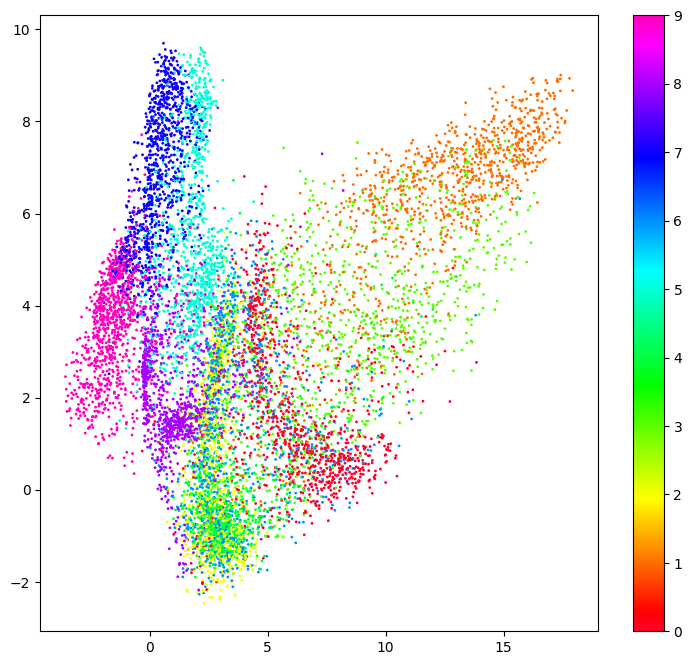

In [124]:
plt.figure(figsize=(9,8))
scatter = plt.scatter(latent_total[:, 0], latent_total[:, 1], c=y_total, s=1, cmap='gist_rainbow')
plt.colorbar(scatter)
plt.show()

In [130]:
mins, maxs = np.min(latent_total, axis=0), np.max(latent_total, axis=0)
sample = np.random.uniform(mins, maxs, size=(18,2))
sample_tensor = torch.tensor(sample)
sample_tensor = sample_tensor.to(device).float()
reconstructions = model.decoder(sample_tensor)

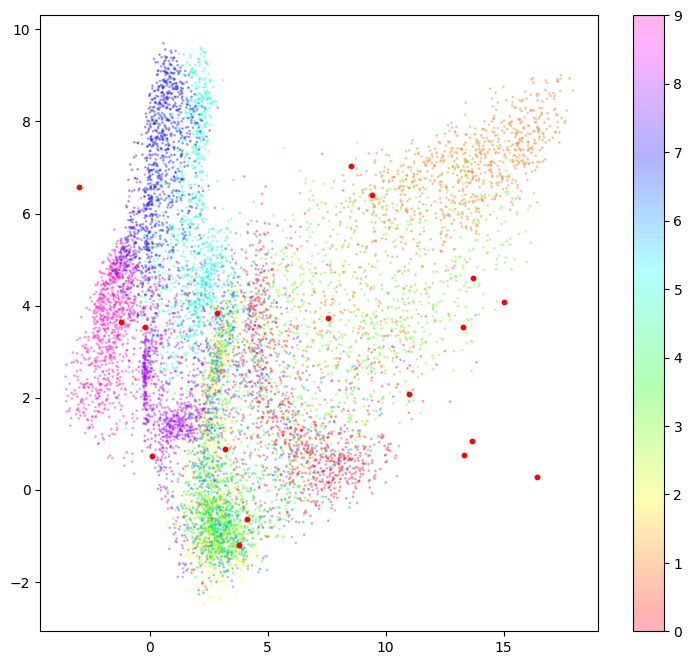

In [135]:
plt.figure(figsize=(9,8))
scatter = plt.scatter(latent_total[:, 0], latent_total[:, 1], c=y_total, s=1, cmap='gist_rainbow', alpha=0.3)
plt.colorbar(scatter)
plt.scatter(sample[:, 0], sample[:, 1], c="r", s=10)
plt.show()

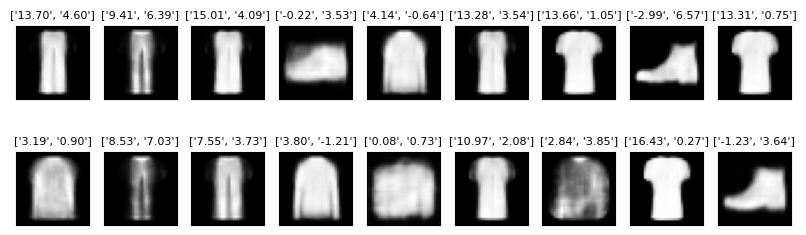

In [149]:
recons = reconstructions.detach().squeeze().cpu().numpy()

fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(10,3))
for i in range(recons.shape[0]):
    plot = axs[i // 9, i % 9]
    plot.set_xticks([])
    plot.set_yticks([])
    plot.imshow(recons[i], cmap='grey')
    
    plot.set_title([f"{v:.2f}" for v in sample[i]], fontsize=8)
    
